In [404]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [405]:
# Load the dataset
df = pd.read_csv('../Data/pre_ADA-USD.csv')
# data = df['Close'].values.reshape(-1, 1)

In [406]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Days_Since_Start
0,0.311973,0.311973,0.288392,0.304397,0.304397,184691008,0
1,0.304424,0.307058,0.288875,0.293504,0.293504,107240000,1
2,0.292952,0.309129,0.292507,0.297106,0.297106,115320000,2
3,0.296285,0.303588,0.286193,0.300787,0.300787,94436000,3
4,0.299897,0.317723,0.291055,0.297622,0.297622,202675008,4


In [407]:
df= df.drop(columns=["Open", "High", "Low", "Adj Close","Volume"])
df = df.rename(columns={'Close': 'Price'})
df = pd.DataFrame(data=df)
data = df

In [408]:
data["Price"]=data["Price"]*100

In [409]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
split_ratio = 0.4
split_index = int(len(data) * split_ratio)
train, test = data.iloc[:split_index], data.iloc[split_index:]

In [410]:
# Bước 1: Tạo các mô hình dự báo có sẵn
def forecast_arima(train, steps):
    model = ARIMA(train, order=(5,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

def forecast_random_forest(train, steps):
    X = np.arange(len(train)).reshape(-1, 1)
    y = train['Price'].values
    model = RandomForestRegressor()
    model.fit(X, y)
    X_pred = np.arange(len(train), len(train) + steps).reshape(-1, 1)
    forecast = model.predict(X_pred)
    return forecast

def forecast_gradient_boosting(train, steps):
    X = np.arange(len(train)).reshape(-1, 1)
    y = train['Price'].values
    model = GradientBoostingRegressor()
    model.fit(X, y)
    X_pred = np.arange(len(train), len(train) + steps).reshape(-1, 1)
    forecast = model.predict(X_pred)
    return forecast

# Dự báo từ các mô hình khác nhau
steps_train = len(train)
steps_test = len(test)
arima_train_forecast = forecast_arima(train['Price'], steps_train)
rf_train_forecast = forecast_random_forest(train, steps_train)
gb_train_forecast = forecast_gradient_boosting(train, steps_train)

In [411]:
# Bước 2: Xây dựng chuỗi lỗi từ dự báo của mỗi thành phần trong ensemble
errors = [train['Price'] - arima_train_forecast[:steps_train],
          train['Price'] - rf_train_forecast[:steps_train],
          train['Price'] - gb_train_forecast[:steps_train]]

# Kiểm tra chiều dài của chuỗi lỗi
for i, error in enumerate(errors):
    print(f"Length of error series {i+1}: {len(error)}")

Length of error series 1: 2742
Length of error series 2: 1371
Length of error series 3: 1371


In [412]:
# Bước 3: Điều chỉnh dự báo của ensemble bằng AR
arima_test_forecast = forecast_arima(train['Price'], steps_test)
rf_test_forecast = forecast_random_forest(train, steps_test)
gb_test_forecast = forecast_gradient_boosting(train, steps_test)

adjusted_forecasts = []
for error, forecast in zip(errors, [arima_test_forecast, rf_test_forecast, gb_test_forecast]):
    error = error[:steps_train]  # Đảm bảo kích thước chuỗi lỗi
    ar_model = ARIMA(error, order=(1,1,1)).fit()
    adjustment = ar_model.forecast(steps=steps_test)
    adjusted_forecast = forecast + adjustment
    adjusted_forecasts.append(adjusted_forecast[:steps_test])  # Đảm bảo kích thước dự báo



c:\Users\kakas\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [413]:
# Bước 4: Tính toán giá trị trung bình và phương sai dự báo
adjusted_forecasts = np.array(adjusted_forecasts)
predictive_mean = np.mean(adjusted_forecasts, axis=0)

sigma1 = np.sqrt(np.mean([np.var(forecast) for forecast in adjusted_forecasts], axis=0))
sigma2 = np.std(adjusted_forecasts, axis=0)
omega = 0.5  # Đây là giá trị ví dụ, có thể được tối ưu hóa
predictive_variance = omega * sigma1 + (1 - omega) * sigma2

In [414]:
# Đánh giá mô hình
mae = mean_absolute_error(test['Price'], predictive_mean)
rmse = np.sqrt(mean_squared_error(test['Price'], predictive_mean))

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')


Mean Absolute Error: 102.60560224720909
Root Mean Squared Error: 106.61541463963846


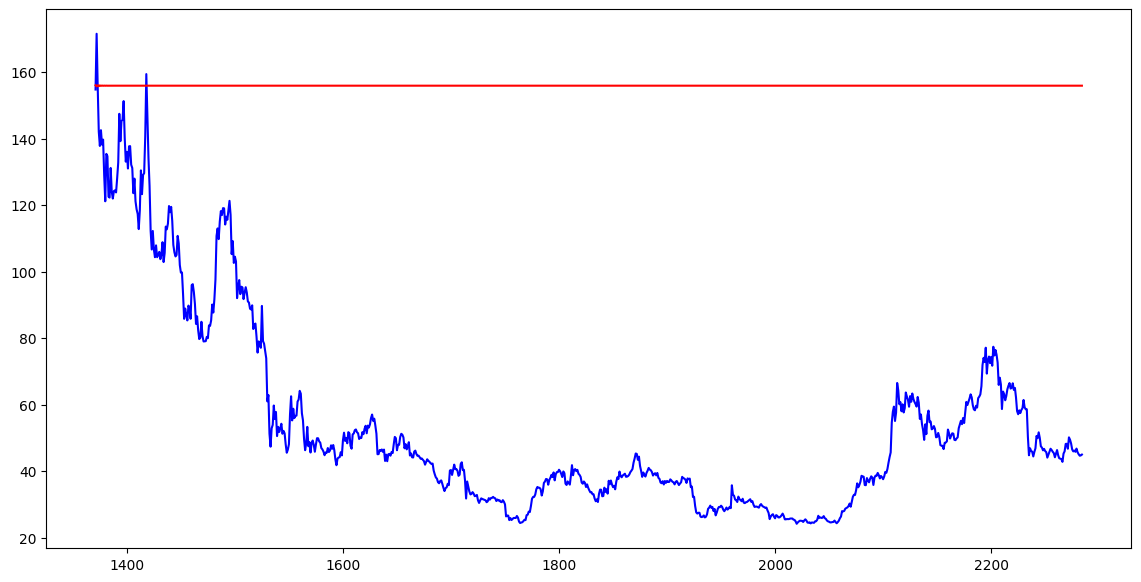

In [415]:
# Vẽ biểu đồ giá trị thực tế và dự báo
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['Price'], label='Actual Price', color='blue')
plt.plot(test.index, predictive_mean, label='Predictive Mean', color='red')

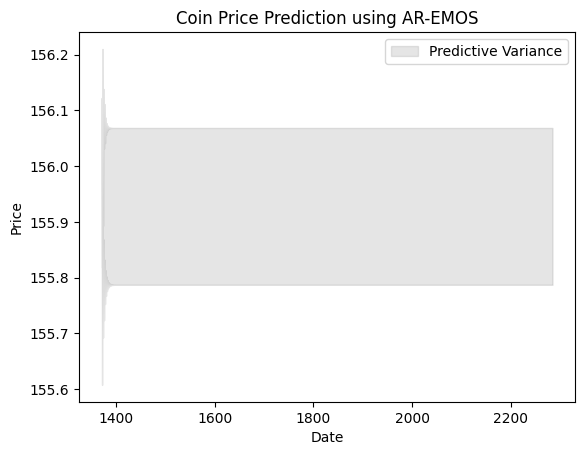

In [416]:
# Vẽ các dải dự báo
upper_bound = predictive_mean + 2 * predictive_variance
lower_bound = predictive_mean - 2 * predictive_variance
plt.fill_between(test.index, lower_bound, upper_bound, color='gray', alpha=0.2, label='Predictive Variance')

plt.title('Coin Price Prediction using AR-EMOS')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()